# Uso del módulo fordward

En el módulo *forward* se implementan algunas formas de resolución del problema directo de imágenes por microondas de un arreglo circular de antenas. Para el caso analítico solo se considera el caso en que el dispersor es un cilindro centrado. En los casos del método de diferencias finitas (FDTD), elementos finitos (FEM), y el método de los momentos (MoM) se pueden generar geometrías más complejas.

- FDTD está implementado en el software [meep](https://meep.readthedocs.io/en/latest/).

- FEM está implementado en el software [FEniCS](https://fenicsproject.org/)***(IMPLEMENTAR).

- MoM está implementado completo basado en [1]***(IMPLEMENTAR).

Libros y publicaciones:

[1] Xudong Chen, Computational Methods for Electromagnetic Inverse Scattering

[2] Matteo Pastorino, Microwave Imaging


Módulo Python: forward

Autores: Ramiro Irastorza 

Email: rirastorza@iflysib.unlp.edu.ar


## Para correr en Google Colab

Ejecutar este documento en forma dinámica:[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rirastorza/Intro2MI/blob/master/problema_directo/sim2.ipynb)

In [ ]:
%%capture
# install conda
!pip install -q condacolab
import condacolab
condacolab.install()
!which conda

# install meep (python)
!conda install -c conda-forge pymeep

## Parallel Meep (MPI version)
!conda create -n pmp -c conda-forge pymeep=*=mpi_mpich_*
!conda activate pmp

In [ ]:
%%capture
!wget https://github.com/rirastorza/Intro2MI/blob/main/problema_directo/forward.py


## Ejemplo de uso para validación con modelo teórico analítico

Primero, se cargan los paquetes necesarios.

In [1]:
from forward import *
import time as tm
#import os
import numpy as np
#from numpy import genfromtxt
import matplotlib.pyplot as plt


### Modelo analítico

El modelo analítico lo implementamos según S. Arslanagic y O. Breinbjerg (2006) [enlace](https://ieeexplore.ieee.org/document/1703397). Es un modelo Transversal Magnético con un campo cilíndrico excitado en dirección z. La implementación es con un cilindro centrado en el origen (0,0) solamente, no se puede modificar el centro del cilindro. Se define la frecuencia, el tamaño de la caja de simulación 25 cm x 25 cm, donde está el arreglo de n antenas (en el ejemplo 4 antenas). Se crean los objetos _TRANSMISOR_parameters_ y _ACOPLANTE_parameters_ y se les asignan las propiedades, de igual manera que el tutorial anterior. Estos objetos contienen información del arreglo de antenas y del fluido de acoplamiento, respectivamente. El acoplante, en este ejemplo, es agua con sal cuyo modelo dieléctrico es un Debye (una frecuencia de relajación) con conductividad iónica.

In [2]:
start_time = tm.strftime('%H:%M:%S')
f = 1.1e9
print('frecuencia de medición (GHz): ',f/1e9)
sx = 0.25
sy = 0.25
box = [sx,sy]
TRANSMISOR_parameters = TRANSMISOR_parameters()
TRANSMISOR_parameters.f = f
TRANSMISOR_parameters.amp = 7.5e4
TRANSMISOR_parameters.rhoS = 0.075
TRANSMISOR_parameters.S = 4.
RECEPTOR_parameters.f = f #frecuencia 1 GHz (por defecto)
RECEPTOR_parameters.amp = 7.5e4#3500 #Amplitud de la fuente
RECEPTOR_parameters.rhoS = 0.075 #radio de transmisores
RECEPTOR_parameters.S = 4 ##cantidad de transmisores (fuentes)
#Coordenadas antenas
angulo = N.linspace(0.0, 2.0*pi, 5)
xantenas = (TRANSMISOR_parameters.rhoS)*N.cos(angulo)
yantenas = (TRANSMISOR_parameters.rhoS)*N.sin(angulo)
#Generación de modelos
r = 25.0e-3/2
Xc = 0.0
Yc = 0.0
print('Xc:', Xc,'Yc:', Yc,'r:',r)
#Dibujo la geometría generada
cilindro = plt.Circle((Xc,Yc),r,fill = False)
frel = 20e9
sigmadc = 400e-3
epsc = 4.8+(77.0-4.8)/(1+1j*TRANSMISOR_parameters.f/frel)+sigmadc/(1j*eps0*2*pi*TRANSMISOR_parameters.f)
ACOPLANTE_parameters = ACOPLANTE_parameters()
ACOPLANTE_parameters.f = TRANSMISOR_parameters.f
ACOPLANTE_parameters.epsr = epsc.real  #frecuencia 1 GHz (por defecto).
ACOPLANTE_parameters.sigma = -epsc.imag*(eps0*2*pi*TRANSMISOR_parameters.f)#conductividad. Entre [0.40, 1.60]
#Comienzo de simulación
cilindro1 = SCATTERER_parameters()
cilindro1.epsr = 2.1 #permitividad relativa. Entre [10.0, 80.0]
cilindro1.sigma = 0.0
cilindro1.f = TRANSMISOR_parameters.f #frecuencia 1 GHz (por defecto).
cilindro1.radio = r
cilindro1.xc = Xc
cilindro1.yc = Yc
print('Permitividad medio:',ACOPLANTE_parameters.epsr)
print('Conductividad medio:',ACOPLANTE_parameters.sigma)
print('Permitividad del cilindro:',cilindro1.epsr)
print('Conductividad del cilindro:',cilindro1.sigma)

frecuencia de medición (GHz):  1.1
Xc: 0.0 Yc: 0.0 r: 0.0125
Permitividad medio: 76.7822536826101
Conductividad medio: 0.642275452117437
Permitividad del cilindro: 2.1
Conductividad del cilindro: 0.0


La función que resuelve el problema analítico se llama: _EZ_CILINDER_LINESOURCE_MATRIZ(eps_data,cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters,tx,deltaX)_. Las entradas son similares a la de la función _Runmeep_ con la diferencia que el primer argumento _eps_data_ es una variable que se utiliza para obtener la grilla discreta donde se quiere calcular el campo. Esta grilla se saca de Meep, en consecuencia primero se debe correr la simulación FDTD con _Runmeep_ y luego la analítica. La salida de la función es una matriz compleja con el valor del campo $E_{z}$ en cada punto de la grilla. 

sxa:  50.0 sxa:  50.0
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 2D dimensions.
Computational cell is 50 x 50 x 0 with resolution 5
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
time for set_epsilon = 0.0530429 s
time for set_conductivity = 0.00289893 s
time for set_conductivity = 0.00373793 s
time for set_conductivity = 0.0048399 s
-----------
Meep: using complex fields.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Meep progress: 342.20000000000005/600.0 = 57.0% done in 4.0s, 3.0s to go
on time step 3427 (time=342.7), 0.0011677 s/step
run 0 finished at t = 600.0 (6000 timesteps)


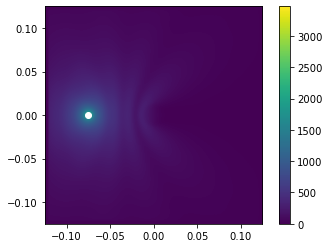

In [3]:
resolucion = 5
n = resolucion*sx/a
tx = 2
xS = (0.15/2)*N.cos(tx*2*pi/4.) #Coordenada x antena emisora
yS = (0.15/2)*N.sin(tx*2*pi/4.)

a = 0.005

Ezfdtd,eps_data = RunMeep(cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters,RECEPTOR_parameters,tx, box,RES = resolucion,calibration = False, unit = a,nt = 300)

plt.figure()
extent2=[-0.25/2,0.25/2,-0.25/2,0.25/2]
plt.imshow(abs(Ezfdtd).transpose(),extent = extent2)#cmap = 'binary')
plt.plot(xS,yS,'ow')
plt.colorbar()
#Dibujo el mapa de permitividad
NN = len(eps_data)
deltaX = sx/(NN)

Ahora calculamos la solución analítica, mediante.

In [4]:
x,Eztheory1 = EZ_CILINDER_LINESOURCE_MATRIZ(eps_data,cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters,tx,deltaX)

Luego dibujamos y comparamos en la posición x = 0, para todo y. 

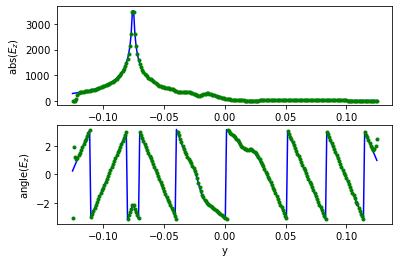

start time:  10:26:17
end time:    10:29:25


In [5]:
x = np.linspace(-len(eps_data)*deltaX/2., len(eps_data)*deltaX/2., len(eps_data))

fig2 = plt.figure(2)
f2 = fig2.add_subplot(211)
f2.plot(x,abs(Eztheory1[:,int(len(Eztheory1)/2)]),'b')
f2.plot(x,abs(Ezfdtd[:,int(len(Ezfdtd)/2)]),'.g')
f2.set_xlabel(r'y')
f2.set_ylabel(r'abs($E_{z}$)')
f2 = fig2.add_subplot(212)
f2.plot(x,N.angle(Eztheory1)[:,int(len(Eztheory1)/2)],'b')
f2.plot(x,-N.angle(Ezfdtd)[:,int(len(Ezfdtd)/2)],'.g')
f2.set_xlabel(r'y')
f2.set_ylabel(r'angle($E_{z}$)')

plt.show()

print('start time: ', start_time)
print('end time:   ', tm.strftime('%H:%M:%S'))

## Conclusión

Remarcamos que para poder llegar a los mismos valores que el analítico, debemos setear la fuente en meep con un valor dado: _TRANSMISOR_parameters.amp = 7.5e4_. Esto puede cambiar si el medio de acoplamiento es otro.

$$E^{inc}_{z}=-I_{e}\frac{\omega\mu_{0}}{4}H^{\left(2\right)}_{0}\left(k_{b}\left|\rho-\rho_{0}\right|\right)$$

En este caso $I_{e} = 1$. 

Como se puede ver, la aproximación con resolución 5 en meep es muy buena y con un tiempo de simulación 600 (600 pasos, está como constante dentro de la función _Runmeep_, la constante nt = 600) ya es suficiente.